In [24]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
# Load the GloVe word embeddings
embeddings_index = {}
with open('glove.6B.50d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [26]:
#Hyperparameter Tuning
test_size = 0.1
validation_size = 0.2
max_len = 200
l1 = 1e-2
l2 = 1e-2
dropout_rate = 0.6
activation = 'relu'
final_activation = 'softmax'
#learning_rate = tf.keras.optimizers.schedules.CosineDecay(0.001, 1000)
learning_rate = 0.001
epochs = 20
batch_size = 32
data_augmentation = True
balance = False

In [27]:
# Load the dataset
df = pd.read_csv('./tcc_ceds_music.csv', delimiter=',')
df.dataframeName = 'tcc_ceds_music.csv'

df.drop(columns=['Unnamed: 0', 'len', 'dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability',
       'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
       'topic', 'age', 'artist_name', 'track_name', 'release_date'], inplace=True)

df.drop(df[df['genre'] == 'pop'].index, inplace = True)
#df.drop(df[df['genre'] == 'country'].index, inplace = True)
#df.drop(df[df['genre'] == 'rock'].index, inplace = True)
#df.drop(df[df['genre'] == 'reggae'].index, inplace = True)
df.drop(df[df['genre'] == 'hip hop'].index, inplace = True)
df.drop(df[df['genre'] == 'blues'].index, inplace = True)
df.drop(df[df['genre'] == 'jazz'].index, inplace = True)

In [28]:
if balance:
  N = 2500
  df = df.groupby('genre')\
      .apply(lambda x: x[:N][['genre', 'lyrics']])

In [29]:
# Check number of rows and columns
print('Dataset shape:', df.shape)

# Check the column names
print('Columns:', df.columns)

# Check for missing values
print('Missing values:', df.isnull().sum())

# Check the distribution of genres
print('Genre distribution:')
print(df['genre'].value_counts())

# Check the average number of words per song
df['num_words'] = df['lyrics'].apply(lambda x: len(str(x).split()))
print('Average number of words per song:', df['num_words'].mean())
print('Max length: ', tf.reduce_max(df['num_words']))

Dataset shape: (11977, 2)
Columns: Index(['genre', 'lyrics'], dtype='object')
Missing values: genre     0
lyrics    0
dtype: int64
Genre distribution:
country    5445
rock       4034
reggae     2498
Name: genre, dtype: int64
Average number of words per song: 71.55189112465558
Max length:  tf.Tensor(199, shape=(), dtype=int64)


In [30]:
# extract the lyrics and genres columns
lyrics = df['lyrics']
genres = df['genre']

# initialize a CountVectorizer object to tokenize the lyrics
vectorizer = CountVectorizer(stop_words='english')

# fit the vectorizer on the lyrics data to create the vocabulary
vectorizer.fit(lyrics)

# transform the lyrics data into a bag-of-words representation
bag_of_words = vectorizer.transform(lyrics)

# print the bag of words for each genre
for genre in set(genres):
    # get the indices of the lyrics belonging to the current genre
    indices = genres == genre
    
    # sum the bag of words of the lyrics belonging to the current genre
    genre_bow = bag_of_words[indices].sum(axis=0)
    
    # get the features (words) in the vocabulary
    features = vectorizer.get_feature_names_out()
    
    # print the bag of words for the current genre
    print(f'Genre: {genre}')
    for i in range(10):
      index = np.where(genre_bow.A[0] == max(genre_bow.A[0]))
      print(f'{features[index][0]} : {max(genre_bow.A[0])}')
      features = np.delete(features,index)
      genre_bow = np.delete(genre_bow,index)
    print()

Genre: country
know : 5836
time : 5230
like : 4569
heart : 4460
come : 3900
away : 2923
life : 2776
leave : 2758
night : 2501
long : 2433

Genre: reggae
like : 3790
know : 3577
come : 2951
time : 2830
yeah : 2492
life : 2212
live : 1981
cause : 1770
feel : 1760
want : 1655

Genre: rock
know : 3878
time : 3471
like : 3094
come : 3036
away : 2936
feel : 2449
life : 2303
live : 2153
want : 2108
yeah : 2096



In [31]:
# Drop missing values
df.dropna(inplace=True)

# Encode the labels
le = LabelEncoder()
df['genre'] = le.fit_transform(df['genre'])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['genre'], test_size=test_size, random_state=42)

# Split the test data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['lyrics'], df['genre'], test_size=validation_size, random_state=42)

# Tokenize the lyrics
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Convert the lyrics to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

if data_augmentation:
  aug_x_train = []
  aug_y_train = y_train.copy(True)

  for lyrics in X_train:
    new_lyrics = np.copy(lyrics)
    np.random.shuffle(new_lyrics)
    aug_x_train.append(new_lyrics)

  X_train = X_train + aug_x_train
  y_train = pd.concat([y_train, aug_y_train], ignore_index=True)

# Pad the sequences to the same length
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [32]:
# Create the embedding matrix
num_words = len(word_index) + 1
embedding_dim = 50
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [33]:
# Define the baseline
model0 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True),
    tf.keras.layers.LSTM(32,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2),activation='tanh',trainable=False),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(3, activation=final_activation)
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
#loss = tf.keras.losses.MeanSquaredError()
model0.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [34]:
model0.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 50)           1277550   
                                                                 
 lstm_2 (LSTM)               (None, 32)                10624     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,288,273
Trainable params: 99
Non-trainable params: 1,288,174
_________________________________________________________________


In [35]:
# Train the model
history0 = model0.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=False, callbacks=[EarlyStopping(patience=5)])

Epoch 1/20
599/599 [==============================] - 10s 9ms/step - loss: 7.7860 - accuracy: 0.4018 - val_loss: 7.7293 - val_accuracy: 0.4854
Epoch 2/20
599/599 [==============================] - 4s 6ms/step - loss: 7.7510 - accuracy: 0.4454 - val_loss: 7.7269 - val_accuracy: 0.4846
Epoch 3/20
599/599 [==============================] - 4s 7ms/step - loss: 7.7429 - accuracy: 0.4600 - val_loss: 7.7263 - val_accuracy: 0.4833
Epoch 4/20
599/599 [==============================] - 4s 6ms/step - loss: 7.7397 - accuracy: 0.4567 - val_loss: 7.7267 - val_accuracy: 0.4825
Epoch 5/20
599/599 [==============================] - 4s 6ms/step - loss: 7.7391 - accuracy: 0.4620 - val_loss: 7.7258 - val_accuracy: 0.4833
Epoch 6/20
599/599 [==============================] - 4s 7ms/step - loss: 7.7390 - accuracy: 0.4591 - val_loss: 7.7256 - val_accuracy: 0.4825
Epoch 7/20
599/599 [==============================] - 4s 7ms/step - loss: 7.7386 - accuracy: 0.4611 - val_loss: 7.7250 - val_accuracy: 0.4950
Epoch

In [36]:
# Evaluate the model
loss, accuracy = model0.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

38/38 [==============================] - 0s 6ms/step - loss: 7.7305 - accuracy: 0.4816
Test Loss: 7.730525970458984
Test Accuracy: 0.48163604736328125


In [37]:
# Define the model 1
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False, mask_zero=True),
    tf.keras.layers.LSTM(32,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2),activation='tanh'),
    #tf.keras.layers.Dropout(dropout_rate),
    #tf.keras.layers.Dense(16, activation=activation),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(3, activation=final_activation)
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
#loss = tf.keras.losses.MeanSquaredError()
model1.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [38]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 50)           1277550   
                                                                 
 lstm_3 (LSTM)               (None, 32)                10624     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,288,273
Trainable params: 10,723
Non-trainable params: 1,277,550
_________________________________________________________________


In [39]:
# Train the model
history1 = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=False, callbacks=[EarlyStopping(patience=5)])

Epoch 1/20
599/599 [==============================] - 14s 14ms/step - loss: 1.7575 - accuracy: 0.4706 - val_loss: 1.0706 - val_accuracy: 0.5138
Epoch 2/20
599/599 [==============================] - 7s 12ms/step - loss: 1.0698 - accuracy: 0.5130 - val_loss: 1.0323 - val_accuracy: 0.5413
Epoch 3/20
599/599 [==============================] - 8s 13ms/step - loss: 1.0450 - accuracy: 0.5246 - val_loss: 1.0188 - val_accuracy: 0.5559
Epoch 4/20
599/599 [==============================] - 7s 12ms/step - loss: 1.0274 - accuracy: 0.5321 - val_loss: 1.0799 - val_accuracy: 0.5054
Epoch 5/20
599/599 [==============================] - 8s 13ms/step - loss: 1.0176 - accuracy: 0.5405 - val_loss: 1.0419 - val_accuracy: 0.5067
Epoch 6/20
599/599 [==============================] - 7s 12ms/step - loss: 1.0232 - accuracy: 0.5361 - val_loss: 1.0208 - val_accuracy: 0.5309
Epoch 7/20
599/599 [==============================] - 7s 12ms/step - loss: 1.0085 - accuracy: 0.5416 - val_loss: 1.0175 - val_accuracy: 0.541

In [40]:
# Evaluate the model
loss, accuracy = model1.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

38/38 [==============================] - 0s 6ms/step - loss: 0.9755 - accuracy: 0.5927
Test Loss: 0.9754635691642761
Test Accuracy: 0.5926544070243835


In [41]:
# Define the model 2
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, 128, input_length=max_len, mask_zero=True),
    tf.keras.layers.GRU(32,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2), activation='tanh'),
    #tf.keras.layers.Dropout(dropout_rate),
    #tf.keras.layers.Dense(16, activation=activation),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(3, activation=final_activation)
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
#loss = tf.keras.losses.MeanSquaredError()
model2.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [42]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 128)          3270528   
                                                                 
 gru (GRU)                   (None, 32)                15552     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                 99        
                                                                 
Total params: 3,286,179
Trainable params: 3,286,179
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Train the model
history2 = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=False, callbacks=[EarlyStopping(patience=5)])

Epoch 1/20
599/599 [==============================] - 60s 92ms/step - loss: 1.9767 - accuracy: 0.4515 - val_loss: 1.1101 - val_accuracy: 0.4708
Epoch 2/20
599/599 [==============================] - 8s 13ms/step - loss: 1.1179 - accuracy: 0.4504 - val_loss: 1.1100 - val_accuracy: 0.4708
Epoch 3/20
599/599 [==============================] - 7s 11ms/step - loss: 1.1167 - accuracy: 0.4506 - val_loss: 1.1106 - val_accuracy: 0.4708
Epoch 4/20
599/599 [==============================] - 8s 14ms/step - loss: 1.1169 - accuracy: 0.4506 - val_loss: 1.1103 - val_accuracy: 0.4708
Epoch 5/20
599/599 [==============================] - 8s 13ms/step - loss: 1.1164 - accuracy: 0.4506 - val_loss: 1.1103 - val_accuracy: 0.4708
Epoch 6/20
599/599 [==============================] - 7s 11ms/step - loss: 1.1161 - accuracy: 0.4506 - val_loss: 1.1105 - val_accuracy: 0.4708
Epoch 7/20
599/599 [==============================] - 8s 13ms/step - loss: 1.1160 - accuracy: 0.4506 - val_loss: 1.1092 - val_accuracy: 0.470

In [44]:
# Evaluate the model
loss, accuracy = model2.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

38/38 [==============================] - 0s 7ms/step - loss: 1.2120 - accuracy: 0.6110
Test Loss: 1.2119951248168945
Test Accuracy: 0.6110183596611023


In [45]:
# Define the model 3
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, 128, input_length=max_len, mask_zero=True),
    tf.keras.layers.SimpleRNN(32,kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2), activation='tanh'),
    #tf.keras.layers.Dropout(dropout_rate),
    #tf.keras.layers.Dense(16, activation=activation),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(3, activation=final_activation)
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
#loss = tf.keras.losses.MeanSquaredError()
model3.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [46]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 200, 128)          3270528   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 3,275,779
Trainable params: 3,275,779
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Train the model
history3 = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=False, callbacks=[EarlyStopping(patience=5)])

Epoch 1/20
599/599 [==============================] - 212s 352ms/step - loss: 1.4899 - accuracy: 0.5415 - val_loss: 0.9618 - val_accuracy: 0.5897
Epoch 2/20
599/599 [==============================] - 179s 299ms/step - loss: 0.9045 - accuracy: 0.6179 - val_loss: 0.9260 - val_accuracy: 0.5989
Epoch 3/20
599/599 [==============================] - 180s 300ms/step - loss: 0.8356 - accuracy: 0.6540 - val_loss: 0.9483 - val_accuracy: 0.5977
Epoch 4/20
599/599 [==============================] - 178s 296ms/step - loss: 0.7879 - accuracy: 0.6843 - val_loss: 1.0531 - val_accuracy: 0.5964
Epoch 5/20
599/599 [==============================] - 179s 299ms/step - loss: 0.7433 - accuracy: 0.7012 - val_loss: 1.0328 - val_accuracy: 0.5935
Epoch 6/20
599/599 [==============================] - 180s 301ms/step - loss: 0.7041 - accuracy: 0.7183 - val_loss: 1.1573 - val_accuracy: 0.5881
Epoch 7/20
599/599 [==============================] - 181s 302ms/step - loss: 0.6795 - accuracy: 0.7283 - val_loss: 1.4134 -

In [48]:
# Evaluate the model
loss, accuracy = model3.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

38/38 [==============================] - 1s 24ms/step - loss: 1.3933 - accuracy: 0.5927
Test Loss: 1.3932740688323975
Test Accuracy: 0.5926544070243835


In [49]:
# Define the model 4
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, 128, input_length=max_len),
    tf.keras.layers.Conv1D(32, 3, activation='tanh',kernel_regularizer=regularizers.L1L2(l1=l1, l2=l2)),
    tf.keras.layers.GlobalMaxPooling1D(),
    #tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(dropout_rate),
    #tf.keras.layers.Dense(16, activation=activation),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(3, activation=final_activation)
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
#loss = tf.keras.losses.MeanSquaredError()
model4.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [50]:
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 128)          3270528   
                                                                 
 conv1d (Conv1D)             (None, 198, 32)           12320     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 3)                 99        
                                                      

In [51]:
# Train the model
history4 = model4.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=False, callbacks=[EarlyStopping(patience=5)])

Epoch 1/20
599/599 [==============================] - 44s 63ms/step - loss: 1.4939 - accuracy: 0.4479 - val_loss: 1.1096 - val_accuracy: 0.4708
Epoch 2/20
599/599 [==============================] - 3s 5ms/step - loss: 1.1175 - accuracy: 0.4506 - val_loss: 1.1102 - val_accuracy: 0.4708
Epoch 3/20
599/599 [==============================] - 3s 4ms/step - loss: 1.1167 - accuracy: 0.4506 - val_loss: 1.1080 - val_accuracy: 0.4708
Epoch 4/20
599/599 [==============================] - 3s 5ms/step - loss: 1.1163 - accuracy: 0.4506 - val_loss: 1.1091 - val_accuracy: 0.4708
Epoch 5/20
599/599 [==============================] - 3s 5ms/step - loss: 1.1171 - accuracy: 0.4506 - val_loss: 1.1094 - val_accuracy: 0.4708
Epoch 6/20
599/599 [==============================] - 3s 6ms/step - loss: 1.1167 - accuracy: 0.4506 - val_loss: 1.1099 - val_accuracy: 0.4708
Epoch 7/20
599/599 [==============================] - 3s 5ms/step - loss: 1.1161 - accuracy: 0.4506 - val_loss: 1.1095 - val_accuracy: 0.4708
Epoc

In [52]:
# Evaluate the model
loss, accuracy = model4.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

38/38 [==============================] - 0s 4ms/step - loss: 1.1136 - accuracy: 0.4583
Test Loss: 1.1136332750320435
Test Accuracy: 0.4582637846469879


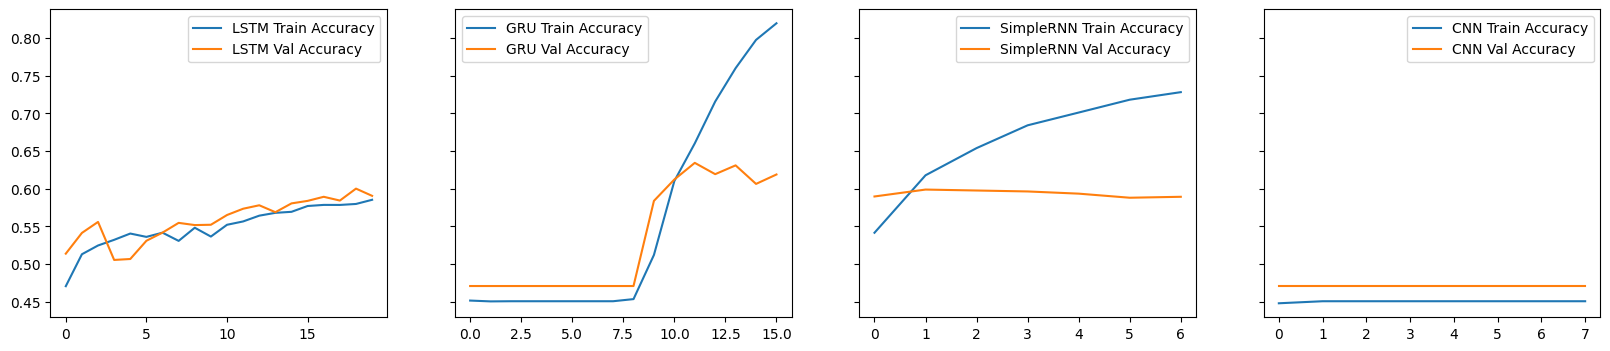

In [53]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20, 4))
ax1.plot(range(len(history1.history['accuracy'])), history1.history['accuracy'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(history1.history['val_accuracy'])), history1.history['val_accuracy'], 
         label='LSTM Val Accuracy');
ax2.plot(range(len(history2.history['accuracy'])), history2.history['accuracy'],
         label='GRU Train Accuracy');
ax2.plot(range(len(history2.history['val_accuracy'])), history2.history['val_accuracy'],
         label='GRU Val Accuracy');
ax3.plot(range(len(history3.history['accuracy'])), history3.history['accuracy'], 
         label='SimpleRNN Train Accuracy');
ax3.plot(range(len(history3.history['val_accuracy'])), history3.history['val_accuracy'], 
         label='SimpleRNN Val Accuracy');
ax4.plot(range(len(history4.history['accuracy'])), history4.history['accuracy'],
         label='CNN Train Accuracy');
ax4.plot(range(len(history4.history['val_accuracy'])), history4.history['val_accuracy'],
         label='CNN Val Accuracy');
ax1.legend();
ax2.legend();
ax3.legend();
ax4.legend();

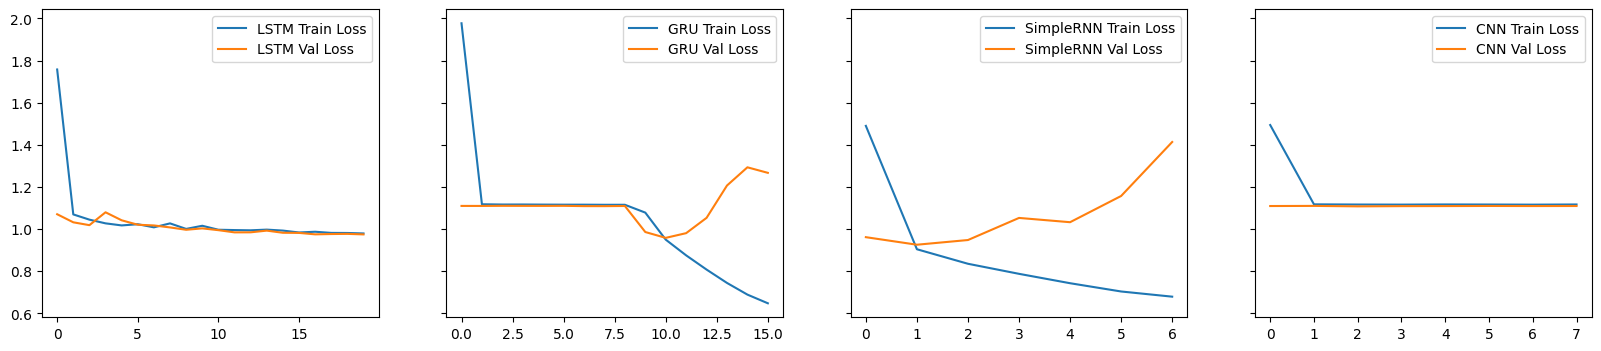

In [54]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(20, 4))
ax1.plot(range(len(history1.history['loss'])), history1.history['loss'], 
         label='LSTM Train Loss');
ax1.plot(range(len(history1.history['val_loss'])), history1.history['val_loss'], 
         label='LSTM Val Loss');
ax2.plot(range(len(history2.history['loss'])), history2.history['loss'],
         label='GRU Train Loss');
ax2.plot(range(len(history2.history['val_loss'])), history2.history['val_loss'],
         label='GRU Val Loss');
ax3.plot(range(len(history3.history['loss'])), history3.history['loss'], 
         label='SimpleRNN Train Loss');
ax3.plot(range(len(history3.history['val_loss'])), history3.history['val_loss'], 
         label='SimpleRNN Val Loss');
ax4.plot(range(len(history4.history['loss'])), history4.history['loss'],
         label='CNN Train Loss');
ax4.plot(range(len(history4.history['val_loss'])), history4.history['val_loss'],
         label='CNN Val Loss');
ax1.legend();
ax2.legend();
ax3.legend();
ax4.legend();

38/38 [==============================] - 1s 5ms/step


Text(0.5, 23.52222222222222, 'Baseline')

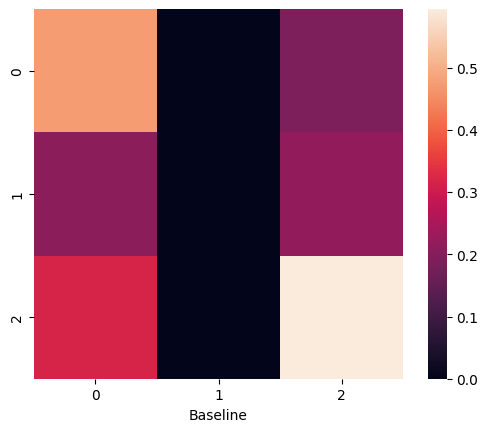

In [55]:
#Predict
y_prediction = np.argmax(model0.predict(X_test),axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

fig = plt.figure()
sns.heatmap(result,square=True)
plt.xlabel("Baseline")

In [56]:
print('f1: ', f1_score(y_test, y_prediction, average='micro'))

f1:  0.48163606010016696


38/38 [==============================] - 2s 7ms/step


Text(0.5, 23.52222222222222, 'LSTM')

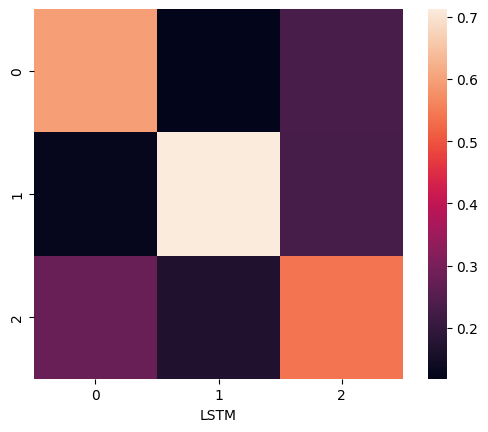

In [57]:
#Predict
y_prediction = np.argmax(model1.predict(X_test),axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

fig = plt.figure()
sns.heatmap(result,square=True)
plt.xlabel("LSTM")

In [65]:
print('f1: ', f1_score(y_test, y_prediction, average='micro'))

f1:  0.4582637729549249


38/38 [==============================] - 1s 5ms/step


Text(0.5, 23.52222222222222, 'GRU')

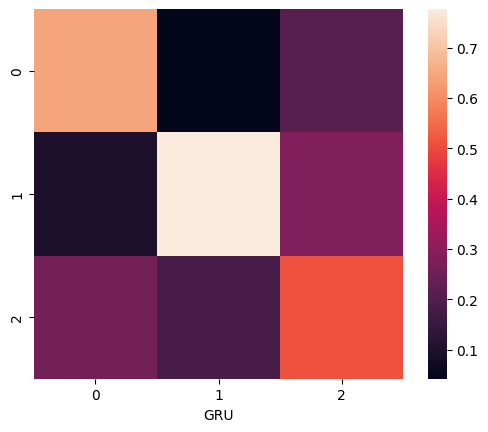

In [59]:
#Predict
y_prediction = np.argmax(model2.predict(X_test),axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

fig = plt.figure()
sns.heatmap(result,square=True)
plt.xlabel("GRU")


In [66]:
print('f1: ', f1_score(y_test, y_prediction, average='micro'))

f1:  0.4582637729549249


38/38 [==============================] - 1s 23ms/step


Text(0.5, 23.52222222222222, 'SimpleRNN')

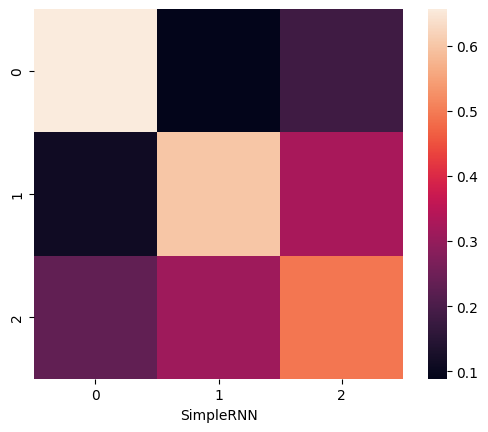

In [61]:
#Predict
y_prediction = np.argmax(model3.predict(X_test),axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

fig = plt.figure()
sns.heatmap(result,square=True)
plt.xlabel("SimpleRNN")

In [67]:
print('f1: ', f1_score(y_test, y_prediction, average='micro'))

f1:  0.4582637729549249


38/38 [==============================] - 0s 2ms/step


Text(0.5, 23.52222222222222, 'CNN')

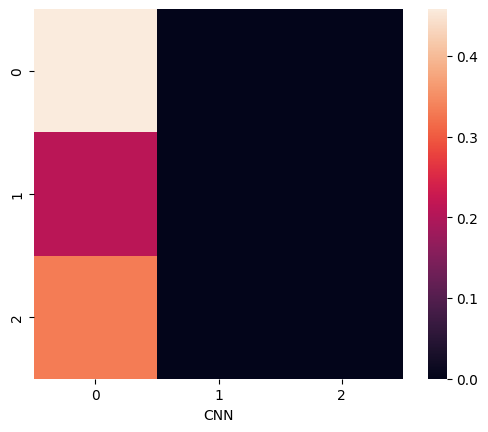

In [63]:
#Predict
y_prediction = np.argmax(model4.predict(X_test),axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

fig = plt.figure()
sns.heatmap(result,square=True)
plt.xlabel("CNN")

In [68]:
print('f1: ', f1_score(y_test, y_prediction, average='micro'))

f1:  0.4582637729549249
